In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Task 1:Linear Regression with Non-Linear Basis Functions

In [2]:
def sample_data(seed=60, num_samples=100, noise_mean=1e-5, noise_variance=1):
    """Returns x_sorted, y_real_sorted, y_noise_sorted"""
    np.random.seed(seed)
    eps = np.random.normal(noise_mean, np.sqrt(noise_variance), num_samples)
    x = np.random.uniform(0, 10, num_samples)
    y_real=(np.log(x)+ 1)*np.cos(x) + np.sin(2*x)
    y_noise=y_real + eps

    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_real_sorted = y_real[sort_idx]
    y_noise_sorted = y_noise[sort_idx]

    return x_sorted, y_real_sorted, y_noise_sorted


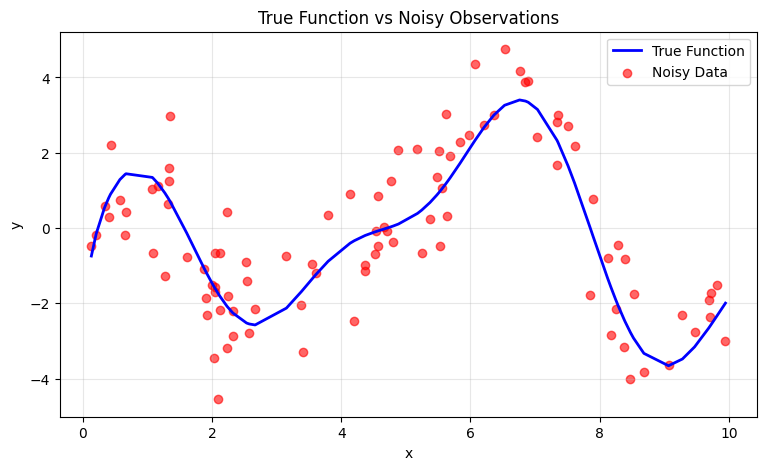

In [3]:
x_true, y_true, y_true_noise = sample_data()
plt.figure(figsize=(9,5))
plt.plot(x_true, y_true, label='True Function', color='blue', linewidth=2)
plt.scatter(x_true, y_true_noise, label='Noisy Data', color='red', alpha=0.6)

plt.xlabel("x")
plt.ylabel("y")
plt.title("True Function vs Noisy Observations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
def gaussian_basis(x,D,dev=1.0):
     x= np.asarray(x) 
     xmin,xmax=np.min(x),np.max(x) 
     if D == 0: 
        return np.ones((len(x), 1)) 
     else: 
        if D == 1: 
            miu = np.array([xmin]) 
        else:
            miu=xmin+(xmax-xmin)/(D-1)* np.arange(D)
        phi=np.exp(-(x[:,None]-np.array(miu)[None, :])**2/(dev**2)) 
        return phi

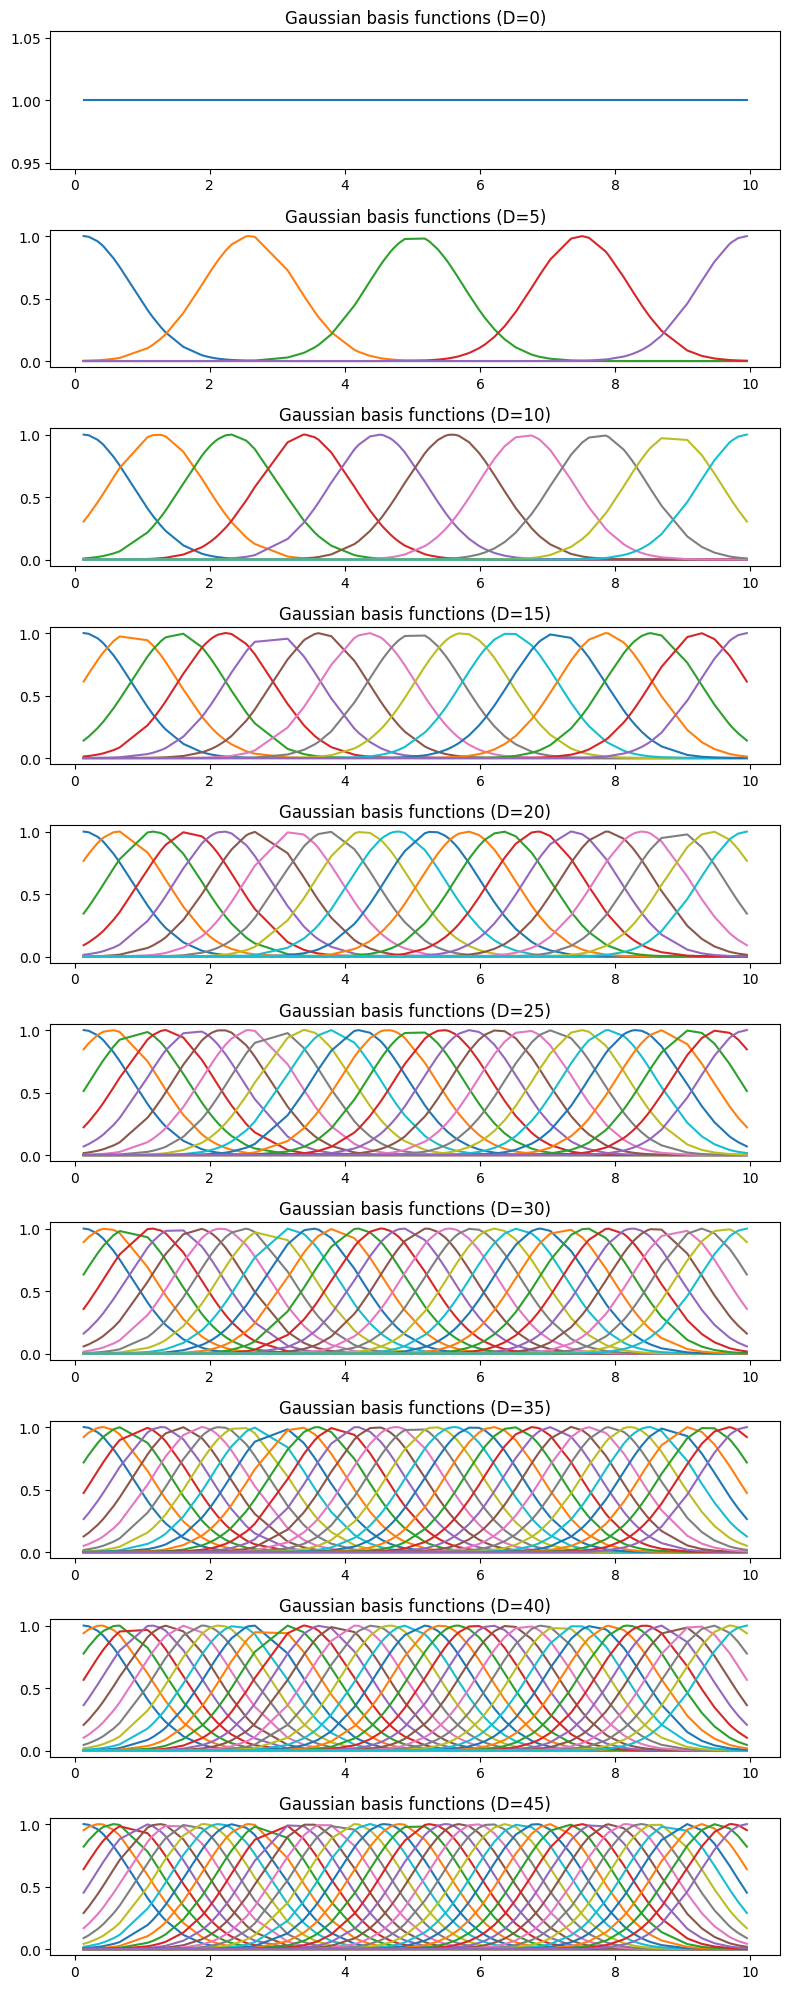

In [5]:
plot_Ds = list(range(0, 46, 5))
# subplot the plots together
fig, axs = plt.subplots(len(plot_Ds), 1, figsize=(8, 2 * len(plot_Ds)))

for i, D in enumerate(plot_Ds): 
    phi = gaussian_basis(x_true, D)
    axs[i].plot(x_true, phi)
    axs[i].set_title(f"Gaussian basis functions (D={D})")

plt.tight_layout()
plt.show()

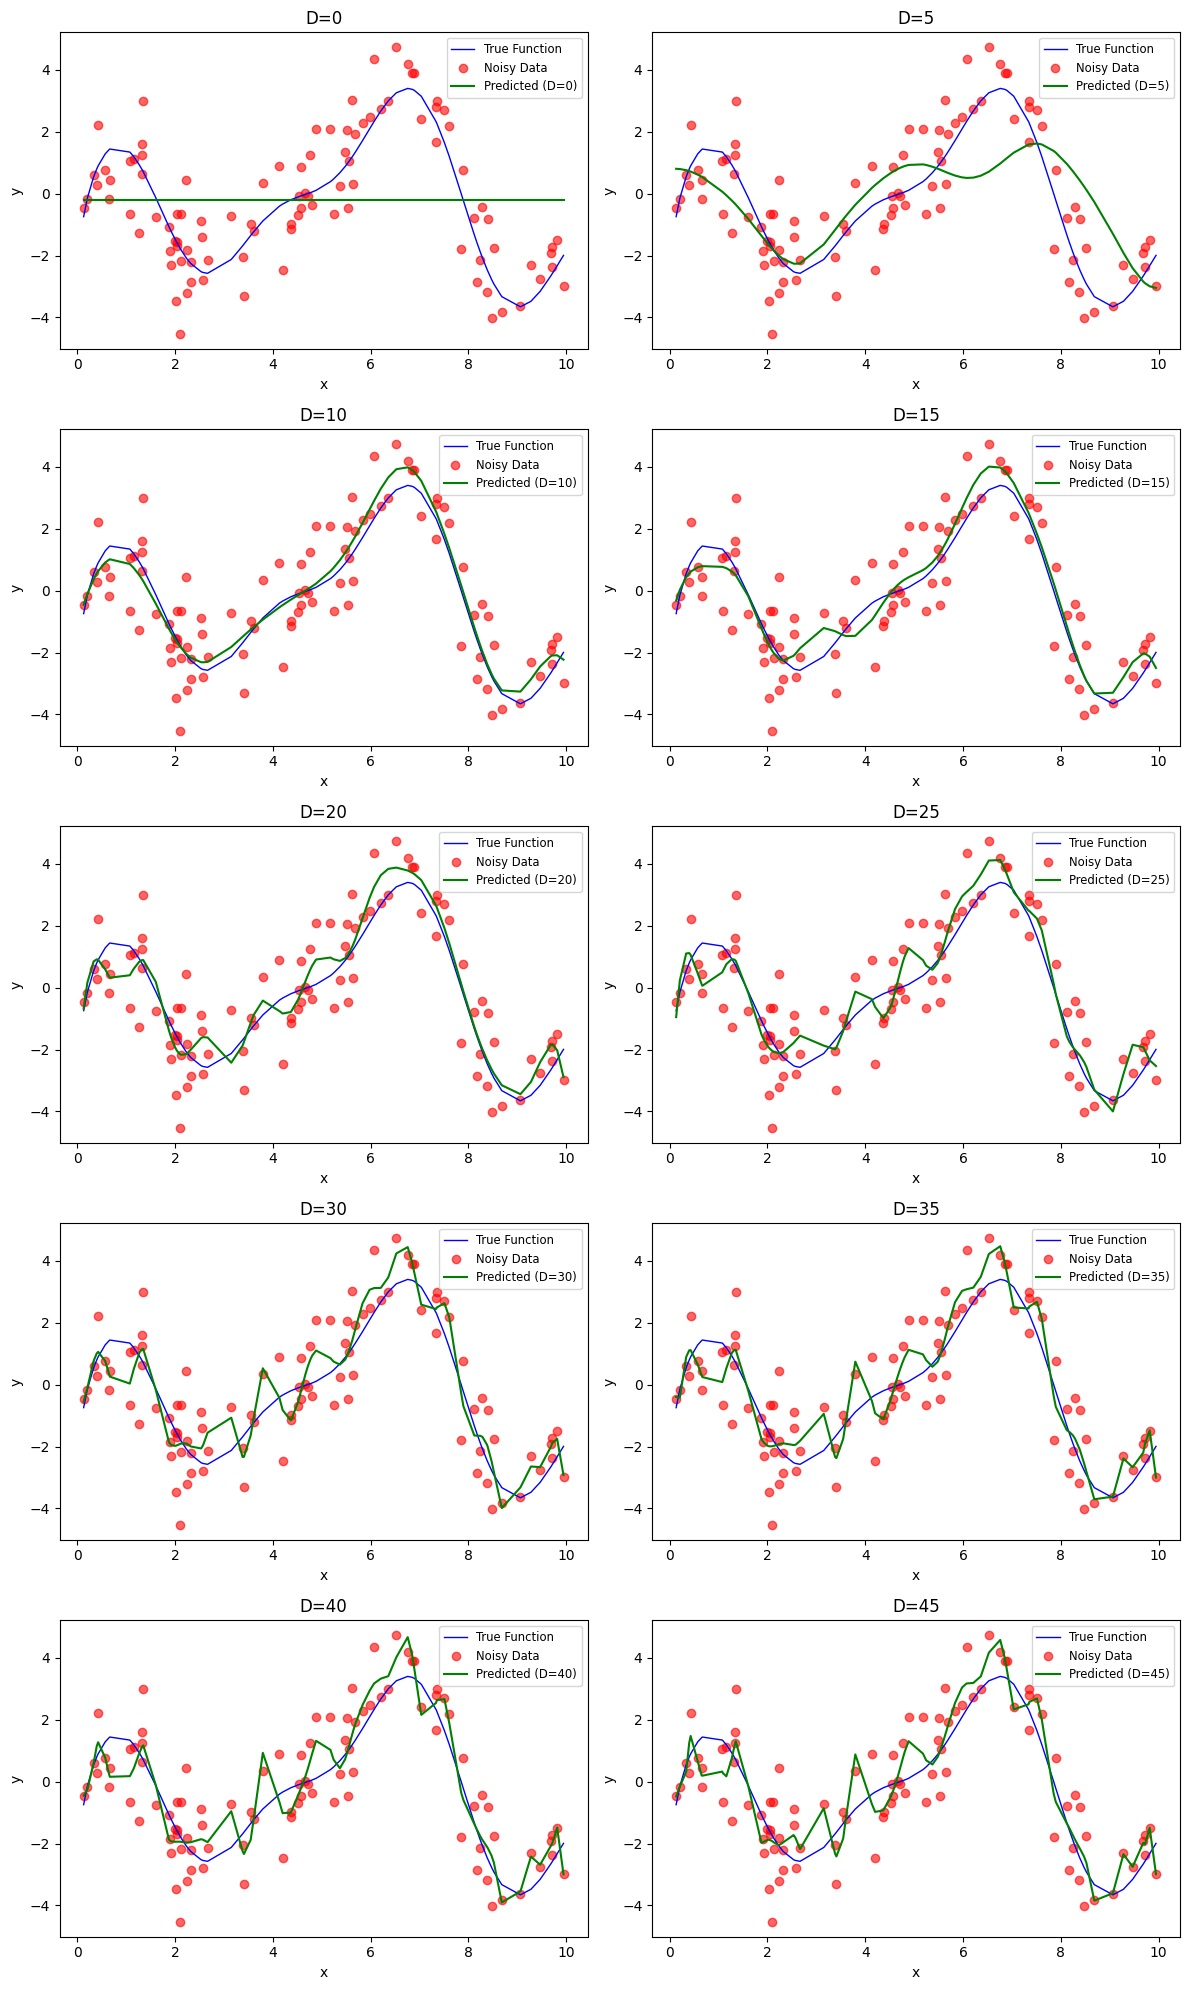

In [6]:
import matplotlib.pyplot as plt
import importlib, Models
importlib.reload(Models)
from Models import LinearRegression

fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
axes = axes.flatten()  # flatten to make indexing easier

for ax, D in zip(axes, plot_Ds):
    phi = gaussian_basis(x_true, D=D)

    model = LinearRegression(optimizer=None)
    model.fit(phi, y_true_noise)
    y_pred = model.predict(phi)

    ax.plot(x_true, y_true, label='True Function', color='blue', linewidth=1)
    ax.scatter(x_true, y_true_noise, label='Noisy Data', color='red', alpha=0.6)
    ax.plot(x_true, y_pred, label=f'Predicted (D={D})', color='green')
    ax.set_title(f'D={D}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(fontsize='small')

# If there are any unused subplots, remove them
for i in range(len(plot_Ds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [7]:
def SSE(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

In [19]:
x_train, x_validation, ynoise_train, ynoise_validation = train_test_split(x_true, y_true_noise, test_size=0.2, random_state=48, shuffle=True)

def model_testing(D):

        phi = gaussian_basis(x_train, D=D)

        model = LinearRegression(optimizer=None)
        model.fit(phi, ynoise_train)
        
        y_pred = model.predict(phi)
        error=SSE(ynoise_train,y_pred)
 
        phi_validation = gaussian_basis(x_validation, D=D)

        y_predv = model.predict(phi_validation)
        errorv=SSE(ynoise_validation,y_predv)
        return error,errorv
        

print(f"{'# Basis':>7} | {'Training error':>20} | {'Validation error':>20}")
print("-" * 55)
for D in plot_Ds:
    error,errorv=model_testing(D) 
    print(f"{D:>7} | {error:>20.6f} | {errorv:>20.6f}")       

# Basis |       Training error |     Validation error
-------------------------------------------------------
      0 |           344.930774 |           100.186503
      5 |           146.761760 |            31.232724
     10 |            87.508696 |            27.560022
     15 |            76.080136 |            72.280268
     20 |            69.757473 |          2168.188447
     25 |            68.970370 |           166.727808
     30 |            64.364217 |       5583959.418057
     35 |            62.376962 |    2710508197.671090
     40 |            61.655628 |    9212663804.851553
     45 |            61.564270 |   49530825416.268860


#### Optimal Model selection

The optimal model for this dataset corresponds to using 20 non-linear Gaussian basis functions. This configuration achieves the lowest validation error while maintaining a low training error, indicating that the model is sufficiently expressive to capture the underlying data patterns without overfitting.

For models with less than 20 basis show high training errors, which suggest that the model is too simplistic and cannot represent the data accurately, a clear sign of underfitting.

For models with more than 20 basis achieve an even lower training error but sugger from a significant increase in validation error. This pattern indicates that using more basis will cause overfitting. The model compexity captures the noise and data fluctuations instead of the underlying relationships

# Task 2: Bias-Variance Tradeoff with Multiple Fits

Basis 0
    Rep |       Training error |     Validation error
Average |           440.904434 |            83.383552
-------------------------------------------------------
Basis 5
    Rep |       Training error |     Validation error
Average |           211.356778 |            50.355637
-------------------------------------------------------
Basis 10
    Rep |       Training error |     Validation error
Average |            74.261774 |            74.853214
-------------------------------------------------------
Basis 15
    Rep |       Training error |     Validation error
Average |            67.085980 |            76.090057
-------------------------------------------------------
Basis 20
    Rep |       Training error |     Validation error
Average |            61.827447 |           848.417881
-------------------------------------------------------
Basis 25
    Rep |       Training error |     Validation error
Average |            56.232167 |         32766.423693
--------------------

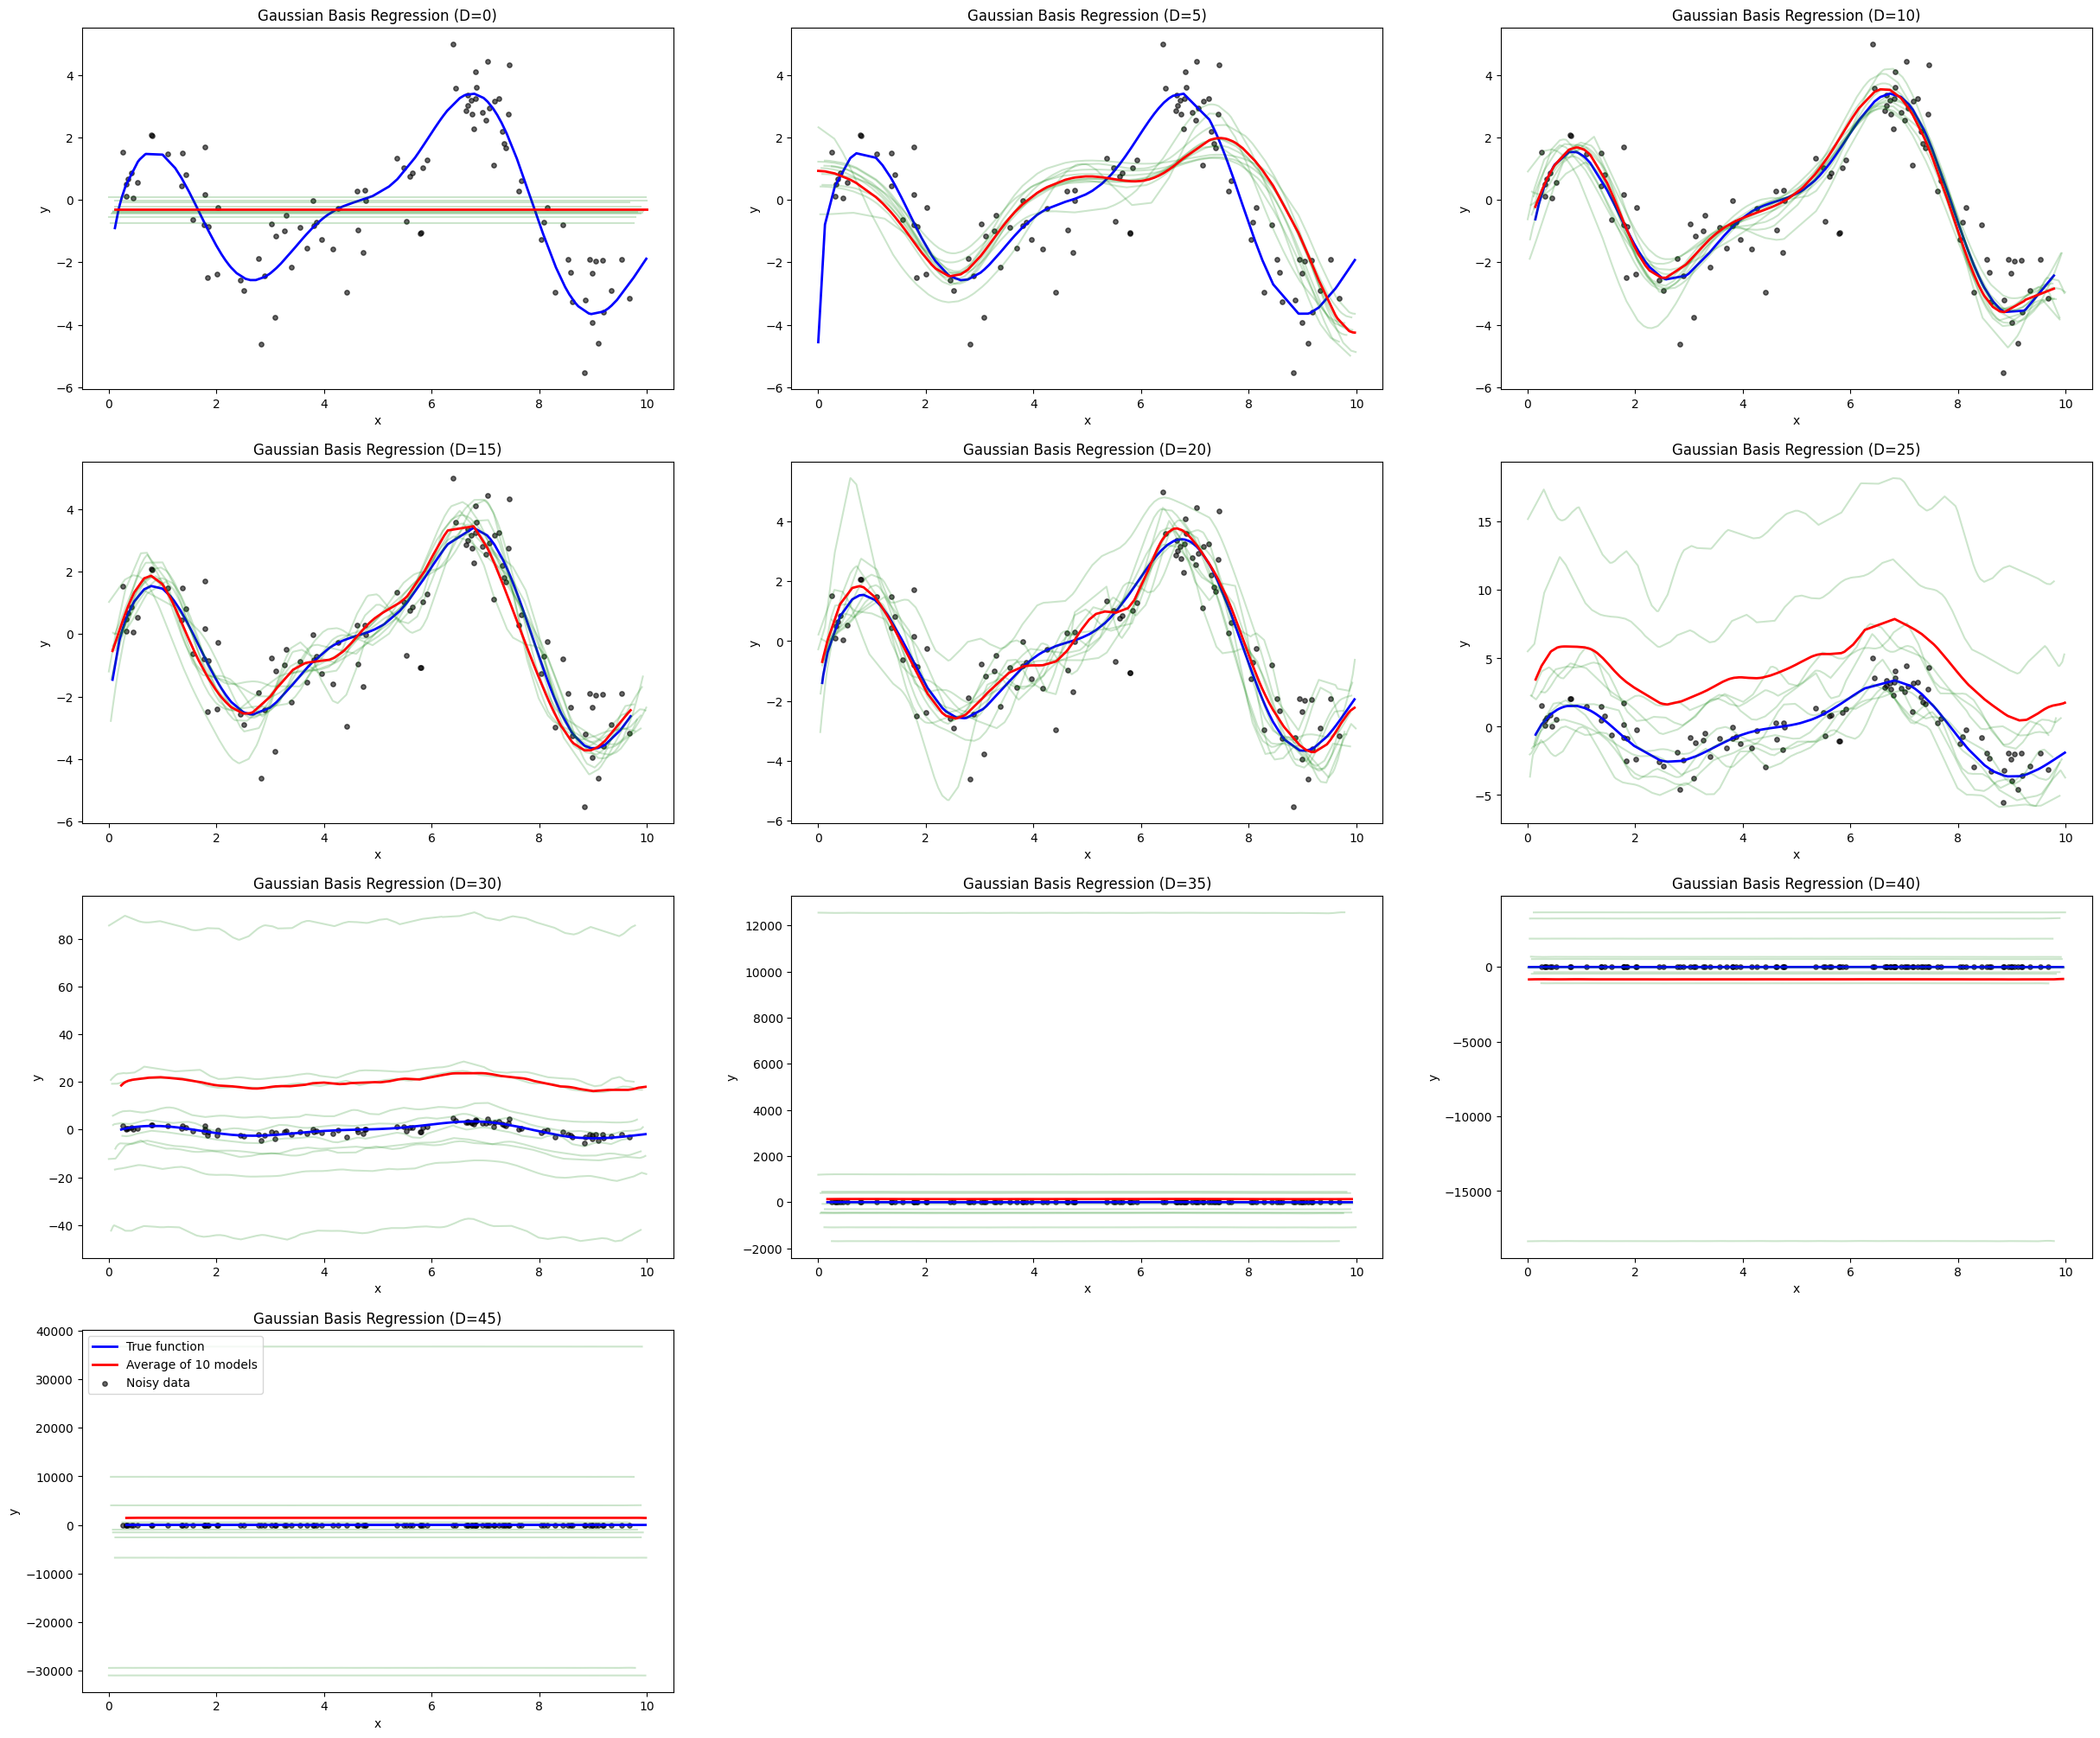

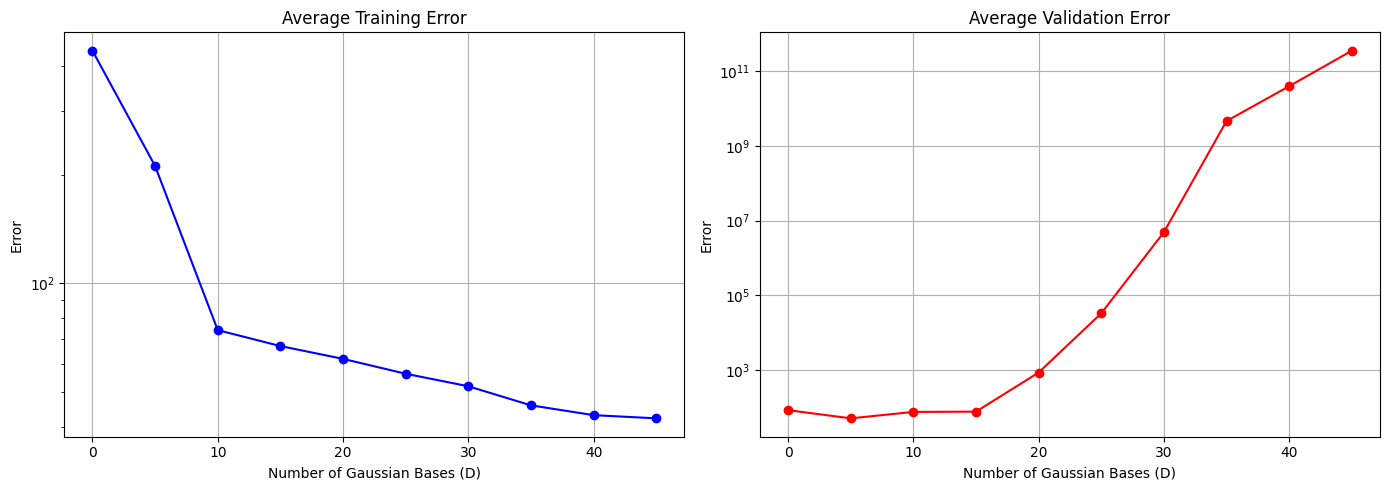

In [9]:
train_errors_avg = []
val_errors_avg = []

plt.figure(figsize=(30, 25))

for idx, D in enumerate(plot_Ds):
    plt.subplot(4,3,idx+1)
    
    plt.title(f"Gaussian Basis Regression (D={D})")
    plt.xlabel("x")
    plt.ylabel("y")
    
    # Plot the true underlying function in blue
    x_true, y_true, _ = sample_data(seed=D)
    plt.plot(x_true, y_true, 'b', linewidth=2, label='True function')
    
    y_preds_all = []
    average_test,average_val=0,0

    print(f"Basis {D}" )
    print(f"{'Rep':>7} | {'Training error':>20} | {'Validation error':>20}")

    for rep in range(10):
        x_sorted, y_real_sorted, y_noise_sorted = sample_data(seed=rep)


        x_train, x_validation, ynoise_train, ynoise_validation = train_test_split(x_sorted, y_noise_sorted, test_size=0.2, random_state=42, shuffle=True)

        phi_train = gaussian_basis(x_train, D=D)

        phi_val = gaussian_basis(x_validation, D=D)


        model = LinearRegression(optimizer=None)
        model.fit(phi_train, ynoise_train)
        y_train_pred = model.predict(phi_train)


        y_val_pred = model.predict(phi_val)


        phi_sorted = gaussian_basis(x_sorted, D=D)

        phi_avg = gaussian_basis(x_true, D=D)

        y_preds_all.append(model.predict(phi_avg))

        plt.plot(x_sorted, model.predict(phi_sorted), color='green', alpha=0.2)

        train_err_sse = SSE(ynoise_train, y_train_pred)
        val_err_sse = SSE(ynoise_validation, y_val_pred)
        if (D==45):
            print("training x", x_train)
            print("Fitted 45D weights:", model.w)
            val_mse = val_err_sse / len(ynoise_validation)
            print(f"Validation MSE for D=45, rep={rep}: {val_mse}")
        average_test += train_err_sse
        average_val += val_err_sse



    avg_train = average_test / 10
    avg_val = average_val / 10
    train_errors_avg.append(avg_train)
    val_errors_avg.append(avg_val)

    print(f"{'Average':>7} | {avg_train:>20.6f} | {avg_val:>20.6f}")
    print("-" * 55)
    # Compute average of the 10 models
    y_pred_avg = np.mean(np.array(y_preds_all), axis=0)
    plt.plot(x_true, y_pred_avg, color='red', linewidth=2, label='Average of 10 models')

    #noisy dataset
    plt.scatter(x_sorted, y_noise_sorted, color='black', s=15, alpha=0.6, label='Noisy data')

plt.legend()
plt.show()


# Plot training and validation errors side by side ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Training error
axes[0].plot(plot_Ds, train_errors_avg, '-o', color='blue')
axes[0].set_title('Average Training Error')
axes[0].set_xlabel('Number of Gaussian Bases (D)')
axes[0].set_ylabel('Error')
axes[0].grid(True)
axes[0].set_yscale("log")

# Validation error
axes[1].plot(plot_Ds, val_errors_avg, '-o', color='red')
axes[1].set_title('Average Validation Error')
axes[1].set_xlabel('Number of Gaussian Bases (D)')
axes[1].set_ylabel('Error')
axes[1].grid(True)
axes[1].set_yscale("log")

plt.tight_layout()
plt.show() 


## Bias and Variance Analysis

Based on the plots obtained from training and fitting 10 models trained under different Gaussian basis several observations can be made about the bias and variance.

Without any basis functions, the fitted models are completely flat. All green lines and the subsequent red average line are far from generalizing to the shape of the data, indicating underfitting due to the inexpressiveness of the model. 

Increasing the number of basis functions (D=5,10,15,20), the green fit better to the true noisy curve, yielding an average curve that aligns nicely with the provided data. There is little variance between the curves themselves, as they stay close to their average model.

Further increasing the number of basis functions (D=25,30,35,40,45), a drastic increase in variance can be observed. The green lines still maintain a shape similar to that of the true data, but they are highly spaced out from one another vertically, yielding average models that become progressively more distant from the real model. Since each green line is a model trained on a random sampling of the data, each model becomes overly fitted to the data it is provided, and therefore when comparing all these overfitted models against one common dataset, high variance can be observed. 

This same effect can be seen in the average train and validation errors. Training error trends downwards with increasing number of bases, whereas validation error initially drops at D=5 once the model generalizes well, but then increases drastically when it becomes overly expressive and overfits to its training data.

# Task 3: Regularization with Cross-Validation

In [10]:
import importlib, Models
importlib.reload(Models)
from Models import LinearRegression
from sklearn.model_selection import KFold
from collections import defaultdict

l1_trained_models = defaultdict(list)
l2_trained_models = defaultdict(list) # for 3.4 plotting bias variance decomposition
def cross_validate_model(model_constructor: LinearRegression, x_data, y_data, num_folds=10):
    all_mse_train = []
    all_mse_val = []

    kf = KFold(n_splits=num_folds)
    run = 0
    for train_idx, val_idx in kf.split(x_data):
        new_model = model_constructor()
        phi = gaussian_basis(x_data, D=45)
        x_train, x_val = phi[train_idx], phi[val_idx]
        y_train, y_val = y_data[train_idx], y_data[val_idx]

        new_model.fit(x_train, y_train)

        if new_model.regularization_mode == "L1":
            l1_trained_models[new_model.regularization_factor].append(new_model)
        elif new_model.regularization_mode == "L2":
            l2_trained_models[new_model.regularization_factor].append(new_model)

        y_train_pred = new_model.predict(x_train)
        y_val_pred = new_model.predict(x_val)

        all_mse_train.append(np.mean((y_train - y_train_pred) ** 2))
        all_mse_val.append(np.mean((y_val - y_val_pred) ** 2))
        run += 1
    return np.mean(all_mse_train), np.mean(all_mse_val)


x_datasets = []
y_datasets = []

for i in range(5):
    x_sorted, _, y_noise_sorted = sample_data(seed=i*42, num_samples=100, noise_mean=0, noise_variance=1)
    x_train, x_validation, y_train, y_val = train_test_split(x_sorted, y_noise_sorted, test_size=0.8, random_state=42, shuffle=True)
    x_datasets.append(x_train)
    y_datasets.append(y_train)


l1_train_results = []
l2_train_results = []
l1_val_results = []
l2_val_results = []

regularization_factors = np.logspace(-3,1,10)

for factor in regularization_factors:
    all_mse_train_L1 = []
    all_mse_val_L1 = []
    all_mse_train_L2 = []
    all_mse_val_L2 = []
    all_mse_train_normal = []
    all_mse_val_normal = []


    model_L1 = lambda: LinearRegression(regularization_mode="L1", regularization_factor=factor, num_epochs=50000)
    model_L2 = lambda: LinearRegression(optimizer=None,regularization_mode="L2", regularization_factor=factor)
    
    for x_dataset, y_dataset in zip(x_datasets, y_datasets):
        mse_train_L1, mse_val_L1 = cross_validate_model(model_L1, x_dataset, y_dataset, num_folds=5)
        all_mse_train_L1.append(mse_train_L1)
        all_mse_val_L1.append(mse_val_L1)

        mse_train_L2, mse_val_L2 = cross_validate_model(model_L2, x_dataset, y_dataset, num_folds=5)
        all_mse_train_L2.append(mse_train_L2)
        all_mse_val_L2.append(mse_val_L2)


    l1_train_results.append(np.mean(all_mse_train_L1))
    l1_val_results.append(np.mean(all_mse_val_L1))
    l2_train_results.append(np.mean(all_mse_train_L2))
    l2_val_results.append(np.mean(all_mse_val_L2))

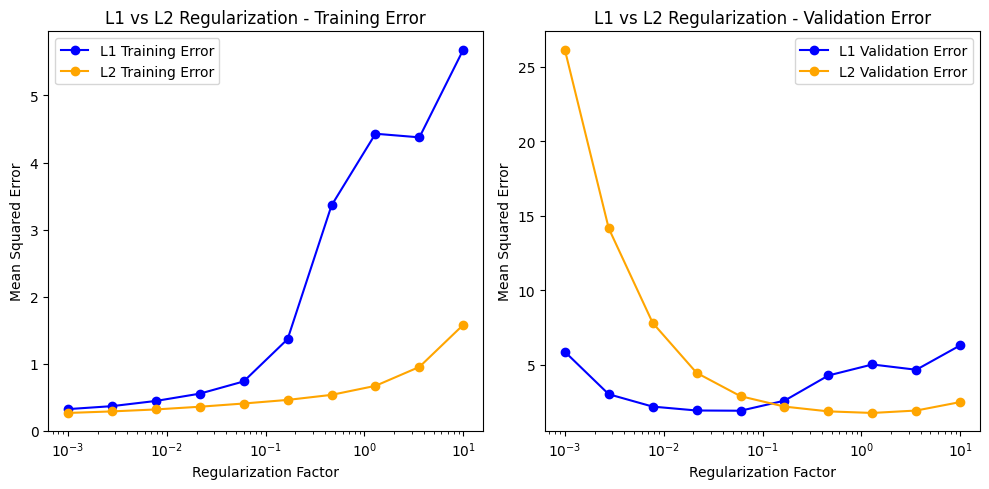

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(regularization_factors, l1_train_results, '-o', label='L1 Training Error', color='blue')
plt.plot(regularization_factors, l2_train_results, '-o', label='L2 Training Error', color='orange')
plt.xscale('log')

plt.xlabel('Regularization Factor')
plt.ylabel('Mean Squared Error')
plt.title('L1 vs L2 Regularization - Training Error')
plt.legend()

plt.subplot(1,2,2)
plt.plot(regularization_factors, l1_val_results, '-o', label='L1 Validation Error', color='blue')
plt.plot(regularization_factors, l2_val_results, '-o', label='L2 Validation Error', color='orange')
plt.xscale('log')
plt.xlabel('Regularization Factor')
plt.ylabel('Mean Squared Error')
plt.title('L1 vs L2 Regularization - Validation Error')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
print(l1_val_results)
print(l2_val_results)

[np.float64(5.8818343819612515), np.float64(3.029618944762479), np.float64(2.1996930428733896), np.float64(1.9381650182570742), np.float64(1.9228444720200577), np.float64(2.5969870683081853), np.float64(4.288676691847179), np.float64(5.027063786446883), np.float64(4.672404192398983), np.float64(6.3106838155489715)]
[np.float64(26.165496263266498), np.float64(14.162256688763915), np.float64(7.819805890375956), np.float64(4.464605774376088), np.float64(2.898192350749909), np.float64(2.199746666804052), np.float64(1.878774413100907), np.float64(1.77352339593028), np.float64(1.936080444095348), np.float64(2.50380741482476)]


In [13]:
x_dataset, y_clean_dataset, y_noisy_dataset = sample_data(seed=0, num_samples=100, noise_mean=0, noise_variance=1)
noise_error = np.mean((y_clean_dataset - np.array(y_noisy_dataset)) ** 2)

def calculate_average_prediction(models):
    predictions = np.array([model.predict(gaussian_basis(x_dataset, D=45)) for model in models])
    average_prediction = np.mean(predictions, axis=0)
    return average_prediction

def calculate_bias(models):
    average_predictions = calculate_average_prediction(models)
    bias = np.mean((average_predictions - y_clean_dataset) ** 2)
    return bias

def calculate_variance(models):
    predictions = np.array([model.predict(gaussian_basis(x_dataset, D=45)) for model in models])
    variance = np.mean(np.var(predictions, axis=0))
    return variance

l1_bias_results = []
l2_bias_results = []
l2_variance_results = []
l1_variance_results = []
for reg_strength in sorted(l1_trained_models.keys()):
    l1_models = l1_trained_models[reg_strength]
    l2_models = l2_trained_models[reg_strength]

    l1_bias = calculate_bias(l1_models)
    l2_bias = calculate_bias(l2_models)
    
    l1_variance = calculate_variance(l1_models)
    l2_variance = calculate_variance(l2_models)    
    
    l1_bias_results.append(l1_bias)
    l2_bias_results.append(l2_bias)
    
    l1_variance_results.append(l1_variance)
    l2_variance_results.append(l2_variance)


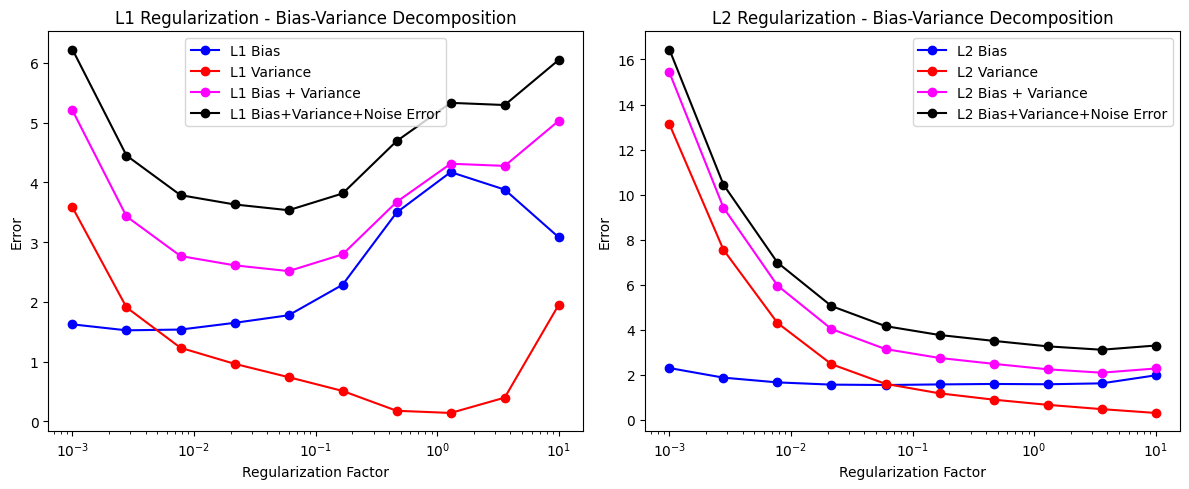

In [14]:


l1_bias_variance = np.array(l1_bias_results) + np.array(l1_variance_results)
l2_bias_variance = np.array(l2_bias_results) + np.array(l2_variance_results)

l1_total_error = l1_bias_variance + noise_error
l2_total_error = l2_bias_variance + noise_error

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(regularization_factors, l1_bias_results, '-o', label='L1 Bias', color='blue')
plt.plot(regularization_factors, l1_variance_results, '-o', label='L1 Variance', color='red')
plt.plot(regularization_factors, l1_bias_variance, '-o', label='L1 Bias + Variance', color='magenta')
plt.plot(regularization_factors, l1_total_error, '-o', label='L1 Bias+Variance+Noise Error', color='black')
plt.xscale('log')
plt.xlabel('Regularization Factor')
plt.ylabel('Error')
plt.title('L1 Regularization - Bias-Variance Decomposition')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regularization_factors, l2_bias_results, '-o', label='L2 Bias', color='blue')
plt.plot(regularization_factors, l2_variance_results, '-o', label='L2 Variance', color='red')
plt.plot(regularization_factors, l2_bias_variance, '-o', label='L2 Bias + Variance', color='magenta')
plt.plot(regularization_factors, l2_total_error, '-o', label='L2 Bias+Variance+Noise Error', color='black')
plt.xscale('log')
plt.xlabel('Regularization Factor')
plt.ylabel('Error')
plt.title('L2 Regularization - Bias-Variance Decomposition')
plt.legend()


plt.tight_layout()
plt.show()

### 3.5: Selecting the Optimal Regularization Strength
From the graph above, the effect of varying regularization strengths on the different sources of error can be observed in both Lasso and Ridge regression. The error is obtained from testing on previously unseen data, meaning it was not used in the training of the various models. In both cases, increasing regularization decreases variance error and increases bias error, albeit at different rates in both cases, with a single outlier in the final data point in L1 regularization slightly breaking from this trend.

The regularization strength can be chosen by finding the minimum of the sum of all 3 sources of error, and choosing the nearest, "round" measured point in that area. This would be a strength of lambda=0.1 for L1 and lambda=1 for L2.

Performing this experiment with more points across a larger space would likely yield more accurate and more performant options to choose from for the regularization strength, but would require more compute than currently available.

## Task 4: Effect of L1 and L2 Regularization on Loss

In [15]:
def task4_sample_data(seed=42, num_samples=30, noise_mean=1e-5, noise_variance=1):
    """Returns x_sorted, y_sorted"""
    np.random.seed(seed)
    eps = np.random.normal(noise_mean, np.sqrt(noise_variance), num_samples)
    x = np.random.uniform(0, 10, num_samples)
    y = -3 * x + 8 + 2 * eps#f(x) = -3x + 8 + 2e

    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]

    return x_sorted, y_sorted#generate sample data

In [16]:
import itertools

def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

cost_fun = lambda w: 0.5 * np.mean((w[0] + w[1] * x - y) ** 2)#MSE loss
l1_penalty = lambda w: np.sum(np.abs(w))#L1 loss
l2_penalty = lambda w: 0.5 * np.dot(w, w)#L2 loss

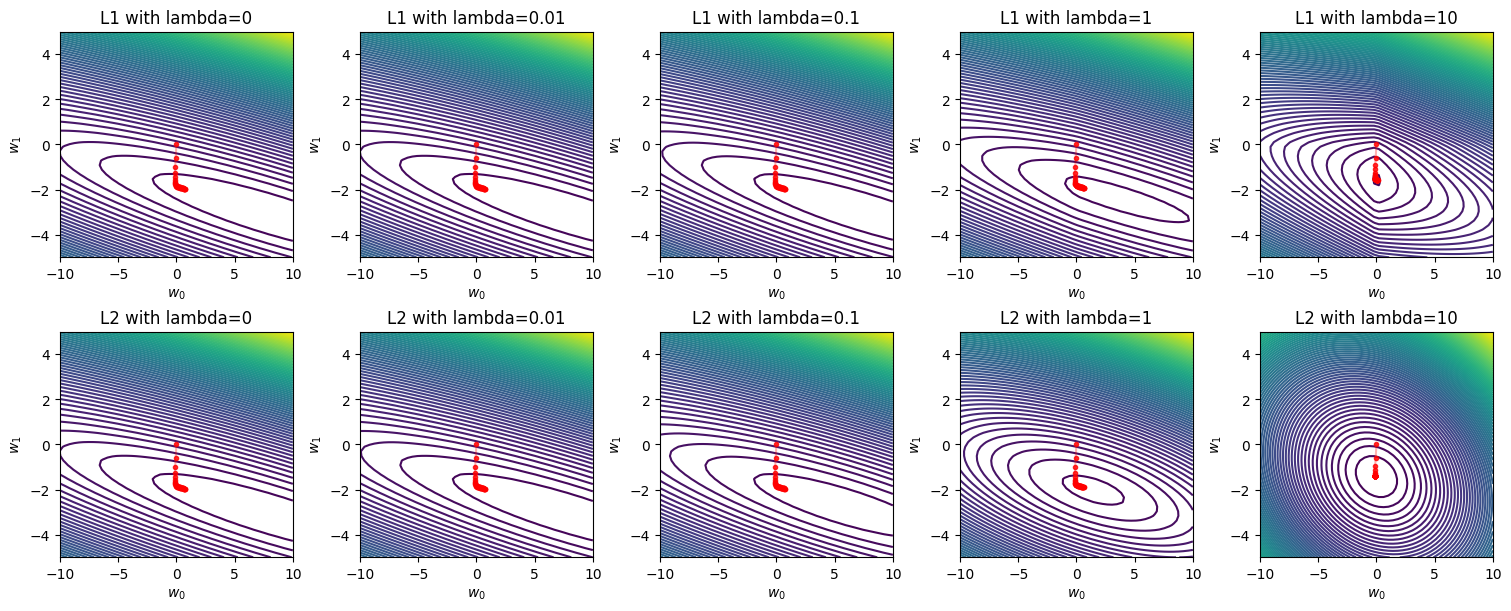

In [18]:
import importlib, Models
importlib.reload(Models)
from Models import LinearRegression, GradientDescent

reg_factors = [0, 0.01, 0.1, 1, 10]

fig, ax = plt.subplots(ncols=5, nrows=2, constrained_layout=True, figsize=(15,6))
x, y = task4_sample_data()
for j, reg_mode in enumerate(["L1", "L2"]):
    for i, factor in enumerate(reg_factors):
        optimizer = GradientDescent(learning_rate=0.01)
        model_l1 = LinearRegression(optimizer=optimizer, num_epochs=50, regularization_mode=reg_mode, regularization_factor=factor)
        model_l1.fit(x, y)
        if reg_mode == "L1":
            reg_cost = lambda w: cost_fun(w) + factor * l1_penalty(w)
        else:
            reg_cost = lambda w: cost_fun(w) + factor * l2_penalty(w)
        plot_contour(reg_cost, [-10, 10], [-5, 5], 50, ax[j][i])
        w_history = np.vstack(optimizer.w_history)
        ax[j][i].plot(w_history[:,1], w_history[:,0], '.r', alpha=0.8)
        ax[j][i].plot(w_history[:,1], w_history[:,0], '-r', alpha=0.3)
        ax[j][i].set_xlabel(r"$w_0$")
        ax[j][i].set_ylabel(r"$w_1$")
        ax[j][i].set_title(f"{reg_mode} with lambda={factor}")
        ax[j][i].set_xlim([-10, 10])
        ax[j][i].set_ylim([-5, 5])
    
plt.show()

#### Analysis of Effects

##### L1 Penalty
From the above graphs, we can observe that for high values of lambda the loss landscape is aggressively compressed along the x and y axes. This leads to the minimizing point in the loss landscape being located exactly at 0 on the x axis and at about -1.5 on the y axis. Given the true function that generated the data: -3x + 8, these results suggest that an L1 penalty encourages nonzero weight values to be concentrated in only a few features. In other words, a high L1 penalty encourages sparsity in trained weights.

##### L2 Penalty
On the other hand, a high L2 penalty seems to compress the loss landscape radially. This encourages weights to be smaller on average. However, compared to L1 regularization, the contours of the loss landscape are smaller, but more rounded. This indicates that, for the same value of lambda, L1 regularization affects specific weights very strongly and others much less, whereas L2 regularization constrains all weights more, but in a more equal manner. Consequently, L2 regularization encourages less sparsity than L1 regularization

##### Lambda
As discussed in the two previous points, for the same value of lambda, L1 regularization will penalize certain weights much more than others, but will produce a less strong penalty on average than L2 regularization.